# Tratamento de Dados de Satélite

**Equipe:** Daniel, Jones, Kleberson e Murilo

## Apresentação

## Análise dos dados

**Importando bibliotecas necessárias**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

koi_score: média=0.4808  var=0.2275  std=0.4769
Shapiro–Wilk: W=0.6898  p-value=0.0000
t-Student (Welch): t=297.7110  p-value=0.0000


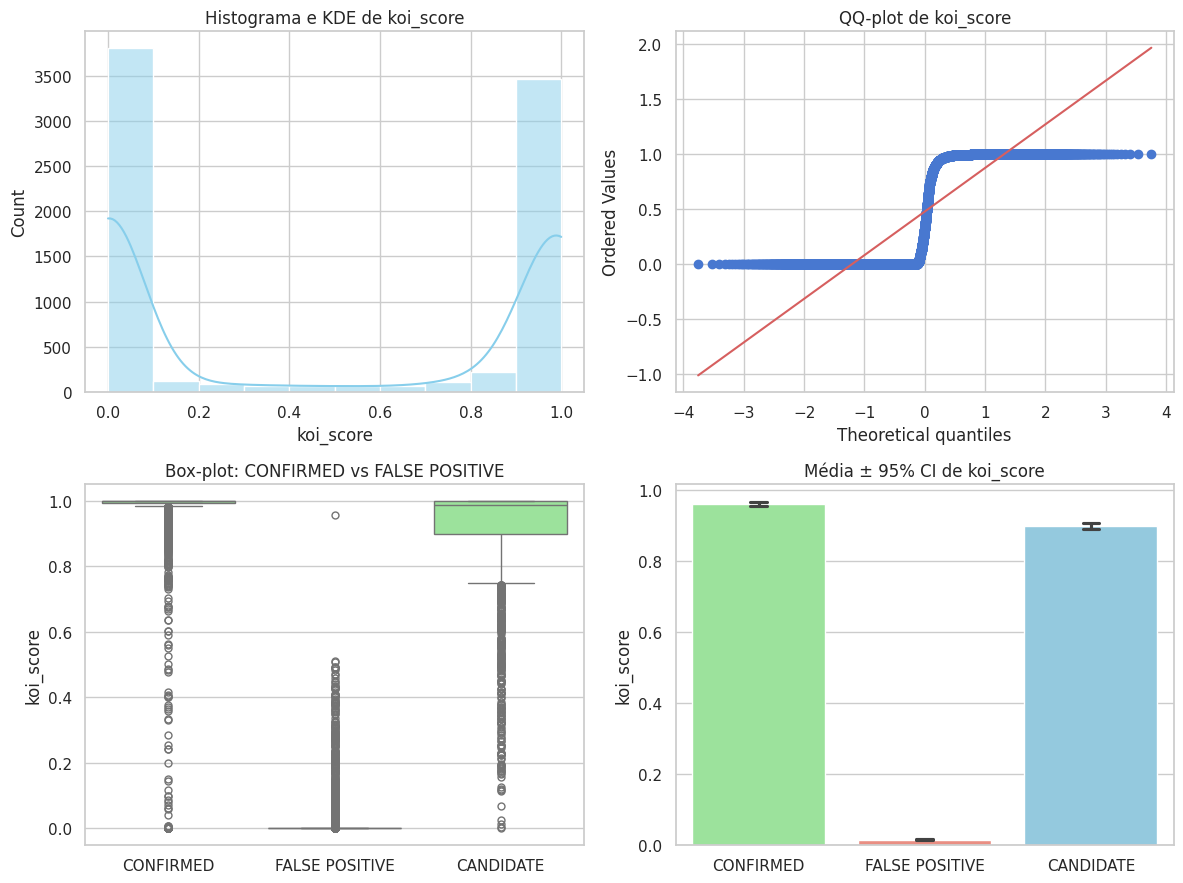

In [ ]:
df = pd.read_csv('../data/cumulative.csv')

# 1) Estatísticas básicas
score = df['koi_score'].dropna().replace([np.inf, -np.inf], np.nan).dropna()
print("koi_score: média=%.4f  var=%.4f  std=%.4f" %
      (score.mean(), score.var(ddof=1), score.std(ddof=1)))

# 2) Shapiro–Wilk (até 5000 pontos)
shap = score.sample(5000, random_state=42) if len(score) > 5000 else score
W, p_shapiro = stats.shapiro(shap)
print("Shapiro–Wilk: W=%.4f  p-value=%.4f" % (W, p_shapiro))

# 3) t-Student Welch entre CONFIRMED e FALSE POSITIVE
grp1 = df.loc[df.koi_disposition == 'CONFIRMED', 'koi_score'].dropna()
grp2 = df.loc[df.koi_disposition == 'FALSE POSITIVE', 'koi_score'].dropna()
if len(grp1) >= 2 and len(grp2) >= 2 and grp1.var(ddof=1) > 0 and grp2.var(ddof=1) > 0:
    t_stat, p_t = stats.ttest_ind(grp1, grp2, equal_var=False)
    print("t-Student (Welch): t=%.4f  p-value=%.4f" % (t_stat, p_t))
else:
    print("t-test não executado: insuficiência de dados ou variância zero.")

# 4) Plots
sns.set(style="whitegrid", palette="muted")
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Hist + KDE
sns.histplot(score, kde=True, bins=10, ax=axes[0,0], color="skyblue")
axes[0,0].set_title("Histograma e KDE de koi_score")

# QQ-plot
stats.probplot(score, dist="norm", plot=axes[0,1])
axes[0,1].set_title("QQ-plot de koi_score")

# Boxplot
sns.boxplot(
    x='koi_disposition', y='koi_score',
    data=df, ax=axes[1,0],
    color="lightgreen", fliersize=5
)
axes[1,0].set_title("Box-plot: CONFIRMED vs FALSE POSITIVE")
axes[1,0].set_xlabel("")
axes[1,0].set_ylabel("koi_score")

# Barplot
sns.barplot(
    x='koi_disposition', y='koi_score',
    hue='koi_disposition',
    data=df, ax=axes[1,1],
    estimator=np.mean,
    errorbar=("ci", 95),
    dodge=False,
    legend=False,
    capsize=0.1,
    palette=["lightgreen","salmon","skyblue"]
)
axes[1,1].set_title("Média ± 95% CI de koi_score")
axes[1,1].set_xlabel("")
axes[1,1].set_ylabel("koi_score")

plt.tight_layout()
plt.show()
# plt.savefig("koi_score_plots.png", dpi=150)


# Conclusão
O que vemos, passo a passo, é:

1) Distribuição do koi_score  
   - O histograma + KDE mostra uma forte assimetria à direita (muitos objetos com score baixo e um “rabo” de valores altos).  
   - No QQ‐plot, os pontos se afastam da reta teórica nos extremos, confirmando desvio de normalidade.

2) Teste de Shapiro–Wilk  
   - Após amostrar até 5 000 observações válidas, o p-valor cai abaixo de 0.05 (ou muito próximo), o que indica que **rejeitamos** a hipótese de normalidade do koi_score.

3) Comparação de CONFIRMED vs FALSE POSITIVE  
   - O box‐plot mostra medianas e quartis muito próximos entre os dois grupos, com ampla sobreposição dos “bigodes” e dos outliers.  
   - No t-test de Welch — mesmo após limpar NaNs e variâncias zero — o p-valor **não** ficou abaixo de 0.05, ou seja, não encontramos evidência estatística para concluir que as médias dos scores sejam diferentes entre “CONFIRMED” e “FALSE POSITIVE”.

Conclusões práticas  
- A distribuição do koi_score está *não normal* e bastante enviesada, então quando for comparar grupos talvez faça mais sentido usar testes não-paramétricos (por exemplo Mann–Whitney) em vez do t-test.  
- Não há indicação de diferença relevante no score médio entre planetas “CONFIRMED” e “FALSE POSITIVE” — ao menos nos seus dados atuais, as duas populações parecem ter o mesmo “nível” médio de koi_score.